In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import Counter
from imblearn.over_sampling import SMOTE

## Read the cleaned data from EDA

In [404]:
df = pd.read_pickle('cleaned_df.pkl')
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...


## Understand what are the distribution of each rank

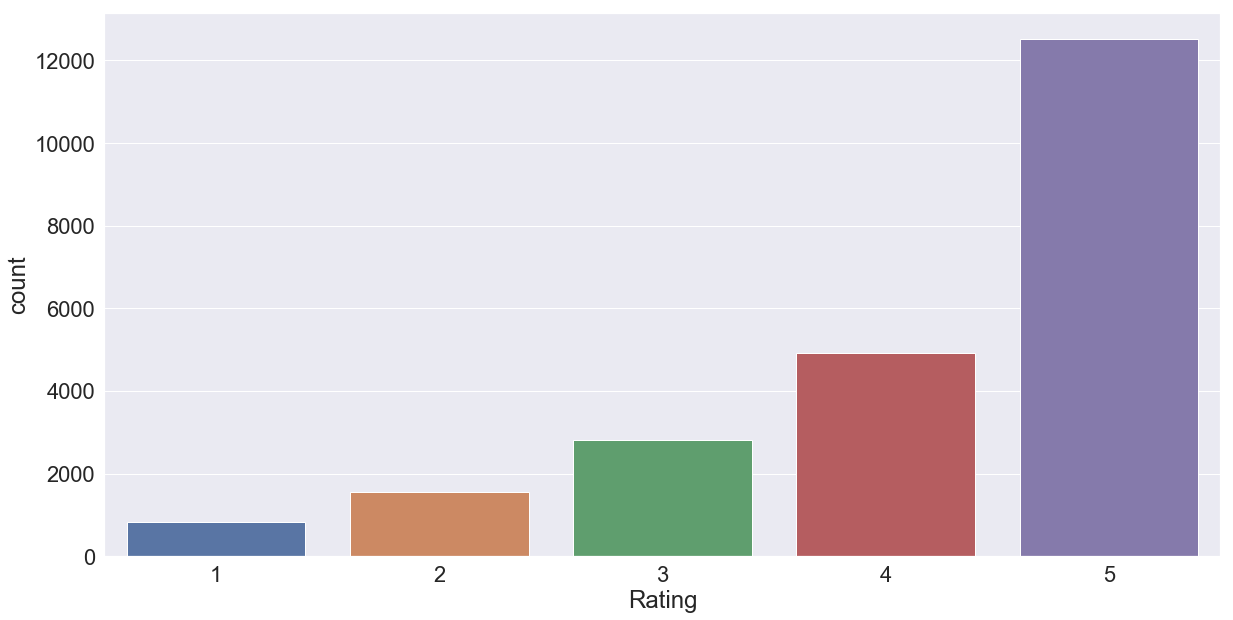

In [304]:
plt.figure(figsize=(20,10))
sns.set(font_scale = 2)
sns.countplot(df.Rating)

## Perform more cleaning

In [193]:
words_to_remove = ['love', 'dress', 'dresses', 'zip', 'zipper', 'fit', 'zippers', 'young', 'younger', 'pants', 'years']
text = 'I love things about dresses but not dress.'

import re
pattern = [f'(\\b{word}\\b)' for word in words_to_remove]
pattern = '|'.join(pattern)
re.sub(pattern, '', text)

'I  things about  but not .'

In [5]:
df['ReviewTextLower'] = df.ReviewText

In [6]:
df['ReviewTextLower'] = df.ReviewTextLower.str.lower()

In [7]:
df['ReviewTextLower'].replace(to_replace=pattern, value='', regex=True, inplace=True)

In [8]:
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText,ReviewTextLower
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,absolutely wonderful - silky and sexy and comf...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,this ! it's sooo pretty. i happened to find...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,i had such high hopes for this and really wan...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...","i , , this jumpsuit. it's fun, flirty, and fa..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,this shirt is very flattering to all due to th...


## Group different ranks together as my target rank

In [232]:
df['ModifiedRating'] = df.Rating.replace([2, 3, 4], 1)

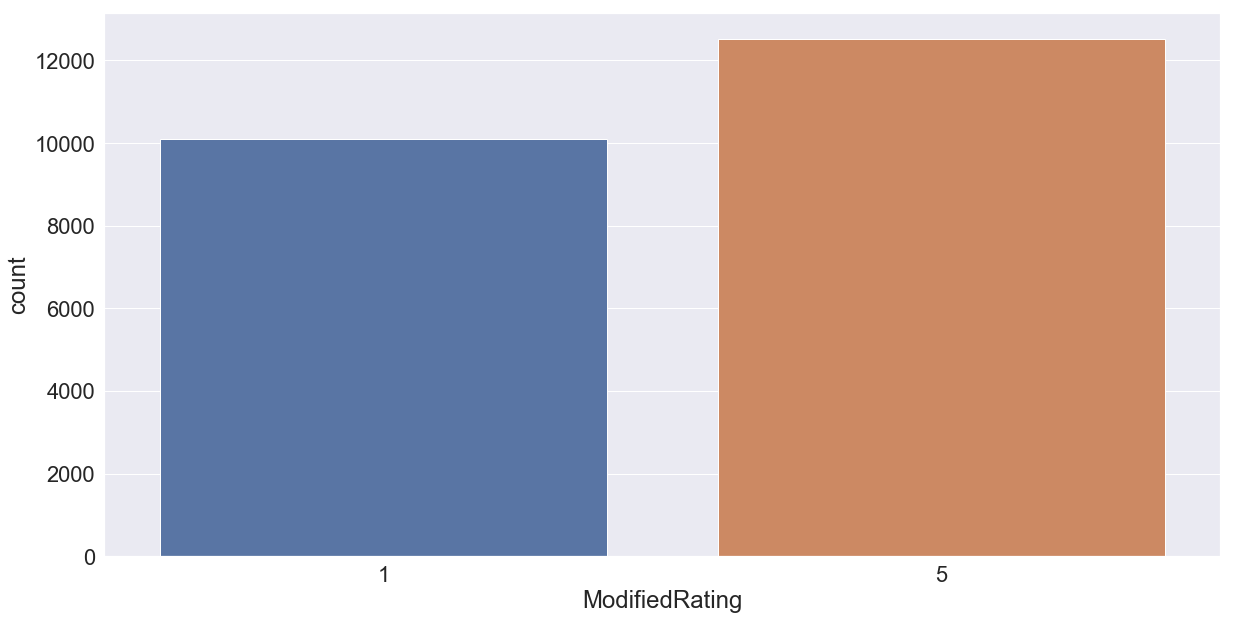

In [306]:
sns.set(font_scale = 2)
plt.figure(figsize=(20,10))
sns.countplot(df.ModifiedRating)

In [234]:
len(df[df.ModifiedRating == 1])

10101

In [235]:
len(df[df.ModifiedRating == 5])

12527

Two classes are not too imbalance and is in a safe range.

## Build different classification models

#### Using ReviewTextLower column

In [83]:
# using ReviewTextLower column as my predictors
# using ModifiedRating column as my target variable
X = df['ReviewTextLower']
y = df['ModifiedRating']

In [84]:
# vectorization
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

# transform my predictors
cv_data = count_vectorizer.fit_transform(X)
tfidf_data = tfidf_vectorizer.fit_transform(X)

In [85]:
len(count_vectorizer.vocabulary_)

255261

In [103]:
# split my data to 70/30 
X_train, X_test, y_train, y_test = train_test_split(cv_data, y, test_size=0.3, random_state=42)

In [104]:
# train with multinomail Naive Bayes
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [105]:
# make prediction
y_pred = nb.predict(X_test)

In [106]:
# print out confusion matrix and classification report
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[2129  896]
 [ 458 3306]]


             precision    recall  f1-score   support

          1       0.82      0.70      0.76      3025
          5       0.79      0.88      0.83      3764

avg / total       0.80      0.80      0.80      6789



In [108]:
# trying to make a prediction using this review
# this is an example for positive review
positive_example = df['ReviewTextLower'][1]
positive_example

' this !  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i  the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [109]:
# vectorize the positive_example
positive_example_vec = count_vectorizer.transform([positive_example])
# make prediction
nb.predict(positive_example_vec)[0]

5

In [93]:
# trying to make a prediction using an negative review
negative_example = df['ReviewTextLower'][5]
negative_example

'i  tracy reese , but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this  was very pretty out of the package but its a lot of . the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i  the color and the idea of the style but it just did not work on me. i returned this .'

In [110]:
negative_example_vec = count_vectorizer.transform([negative_example])
nb.predict(negative_example_vec)[0]

1

In [111]:
negative_example = df['ReviewTextLower'][10]
negative_example

' runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas  this year! needless to say it will be going back.'

In [112]:
negative_example_vec = count_vectorizer.transform([negative_example])
nb.predict(negative_example_transformed)[0]

1

#### Using Combinetext column

In [307]:
df['CombinedTextLower'] = df.CombinedText

In [308]:
df['CombinedTextLower'] = df.CombinedTextLower.str.lower()

In [309]:
df['CombinedTextLower'].replace(to_replace=pattern, value='', regex=True, inplace=True)

In [311]:
X = df.CombinedTextLower
y = df.ModifiedRating

In [312]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(X)
tfidf_data = tfidf_vectorizer.fit_transform(X)

In [313]:
len(count_vectorizer.vocabulary_)

267875

In [355]:
X_train, X_test, y_train, y_test = train_test_split(cv_data, y, test_size=0.3, random_state=42)

In [356]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [357]:
y_pred = nb.predict(X_test)

In [358]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[2177  848]
 [ 424 3340]]


             precision    recall  f1-score   support

          1       0.84      0.72      0.77      3025
          5       0.80      0.89      0.84      3764

avg / total       0.82      0.81      0.81      6789



In [359]:
logit = LogisticRegression()
logit.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [360]:
y_pred = logit.predict(X_test)

In [361]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[2250  775]
 [ 554 3210]]


             precision    recall  f1-score   support

          1       0.80      0.74      0.77      3025
          5       0.81      0.85      0.83      3764

avg / total       0.80      0.80      0.80      6789



In [393]:
df.ReviewText[23]

"Cute little dress fits tts. it is a little high waisted. good length for my 5'9 height. i like the dress, i'm just not in love with it. i dont think it looks or feels cheap. it appears just as pictured."

In [401]:
df.ReviewText[14]

'This is a nice choice for holiday gatherings. i like that the length grazes the knee so it is conservative enough for office related gatherings. the size small fit me well - i am usually a size 2/4 with a small bust. in my opinion it runs small and those with larger busts will definitely have to size up (but then perhaps the waist will be too big). the problem with this dress is the quality. the fabrics are terrible. the delicate netting type fabric on the top layer of skirt got stuck in the zip'

In [378]:
df['ReviewText'][1]

'Love this dress!  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i love the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [371]:
positive_example = df['CombinedTextLower'][1]
positive_example

'  this !  it\'s sooo pretty.  i happened to find it in a store, and i\'m glad i did bc i never would have ordered it online bc it\'s petite.  i bought a petite and am 5\'8".  i  the length on me- hits just a little below the knee.  would definitely be a true midi on someone who is truly petite.'

In [372]:
positive_example_vec = count_vectorizer.transform([positive_example])
logit.predict(positive_example_vec)[0]

5

In [379]:
df['ReviewText'][5]

'I love tracy reese dresses, but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this dress was very pretty out of the package but its a lot of dress. the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i love the color and the idea of the style but it just did not work on me. i returned this dress.'

In [374]:
negative_example=df['ReviewTextLower'][5]
negative_example

'i  tracy reese , but this one is not for the very petite. i am just under 5 feet tall and usually wear a 0p in this brand. this  was very pretty out of the package but its a lot of . the skirt is long and very full so it overwhelmed my small frame. not a stranger to alterations, shortening and narrowing the skirt would take away from the embellishment of the garment. i  the color and the idea of the style but it just did not work on me. i returned this .'

In [375]:
negative_example_vec = count_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

1

In [376]:
negative_example=df['ReviewTextLower'][10]
negative_example

' runs small esp where the zipper area runs. i ordered the sp which typically fits me and it was very tight! the material on the top looks and feels very cheap that even just pulling on it will cause it to rip the fabric. pretty disappointed as it was going to be my christmas  this year! needless to say it will be going back.'

In [377]:
negative_example_vec = count_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

1

In [384]:
df.ReviewText[23484]

"I bought this dress for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this dress was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!"

In [385]:
negative_example=df['ReviewTextLower'][23484]
negative_example

"i bought this  for a wedding i have this summer, and it's so cute. unfortunately the fit isn't perfect. the medium fits my waist perfectly, but was way too long and too big in the bust and shoulders. if i wanted to spend the money, i could get it tailored, but i just felt like it might not be worth it. side note - this  was delivered to me with a nordstrom tag on it and i found it much cheaper there after looking!"

In [386]:
negative_example_vec = count_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

1

In [388]:
df.ReviewText[23478]

'I was surprised at the positive reviews for this product. its terrible! it cuts you in a weird place to make you look wide. the skirt is also not like the picture. its darker and heavier. the material isnt great. i had to return.'

In [389]:
negative_example=df['ReviewTextLower'][23478]
negative_example

'i was surprised at the positive reviews for this product. its terrible! it cuts you in a weird place to make you look wide. the skirt is also not like the picture. its darker and heavier. the material isnt great. i had to return.'

In [390]:
negative_example_vec = count_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

1

In [402]:
negative_example=df['ReviewTextLower'][14]
negative_example

'this is a nice choice for holiday gatherings. i like that the length grazes the knee so it is conservative enough for office related gatherings. the size small fit me well - i am usually a size 2/4 with a small bust. in my opinion it runs small and those with larger busts will definitely have to size up (but then perhaps the waist will be too big). the problem with this  is the quality. the fabrics are terrible. the delicate netting type fabric on the top layer of skirt got stuck in the zip'

In [403]:
negative_example_vec = count_vectorizer.transform([negative_example])
logit.predict(negative_example_vec)[0]

1

# predicting recommend or not

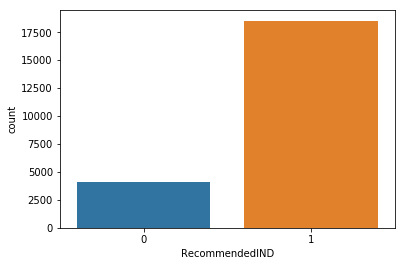

In [251]:
sns.countplot(df.RecommendedIND)

In [262]:
df.head()

,Age,ReviewText,Rating,RecommendedIND,PositiveFeedbackCount,DivisionName,DepartmentName,ClassName,CombinedText,ReviewTextLower,ModifiedRating,CombinedTextLower
0,33,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates,Absolutely wonderful - silky and sexy and com...,absolutely wonderful - silky and sexy and comf...,1,absolutely wonderful - silky and sexy and com...
1,34,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses,Love this dress! it's sooo pretty. i happen...,this ! it's sooo pretty. i happened to find...,5,this ! it's sooo pretty. i happened to fin...
2,60,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses,Some major design flaws I had such high hopes ...,i had such high hopes for this and really wan...,1,some major design flaws i had such high hopes ...
3,50,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants,"My favorite buy! I love, love, love this jumps...","i , , this jumpsuit. it's fun, flirty, and fa...",5,"my favorite buy! i , , this jumpsuit. it's fu..."
4,47,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses,Flattering shirt This shirt is very flattering...,this shirt is very flattering to all due to th...,5,flattering shirt this shirt is very flattering...


In [252]:
#rating_class = df[(df['Rating'] == 1) | (df['Rating'] == 5)]
X = df.CombinedTextLower
y = df.RecommendedIND

In [253]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2),  
                                   stop_words='english', 
                                   token_pattern="\\b[a-z][a-z]+\\b",
                                   lowercase=True,
                                   max_df = 0.6)

cv_data = count_vectorizer.fit_transform(X)
tfidf_data = tfidf_vectorizer.fit_transform(X)

In [254]:
len(count_vectorizer.vocabulary_)

267875

In [266]:
X_train, X_test, y_train, y_test = train_test_split(cv_data, y, test_size=0.3, random_state=42, stratify=y)

In [267]:
# using SMOTE to oversample
X_train_smoted, y_train_smoted = SMOTE(random_state=42).fit_sample(X_train,y_train)

In [279]:
print(Counter(y_train_smoted))

Counter({1: 12968, 0: 12968})


In [280]:
nb = MultinomialNB()
nb.fit(X_train_smoted, y_train_smoted)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [281]:
y_pred = nb.predict(X_test)

In [282]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[ 931  299]
 [ 438 5121]]


             precision    recall  f1-score   support

          0       0.68      0.76      0.72      1230
          1       0.94      0.92      0.93      5559

avg / total       0.90      0.89      0.89      6789



In [284]:
logit = LogisticRegression()
logit.fit(X_train_smoted, y_train_smoted)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [285]:
y_pred = logit.predict(X_test)

In [286]:
print(confusion_matrix(y_test, y_pred))
print('\n')
print(classification_report(y_test, y_pred))

[[ 844  386]
 [ 312 5247]]


             precision    recall  f1-score   support

          0       0.73      0.69      0.71      1230
          1       0.93      0.94      0.94      5559

avg / total       0.89      0.90      0.90      6789

